In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report,plot_confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from cmath import sqrt

import statsmodels.api as sm

from tabulate import tabulate

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 351 kB/s 


# 3. Featrue Engineering

In [ ]:
def p_value_check(dfs, numerical_col, result_col):
  dfs_label_encoder = dfs.copy()

  le = LabelEncoder()
  dfs_label_encoder_cols = dfs_label_encoder.columns
  encode_cols = [x for x in dfs_label_encoder_cols if x not in numerical_col]

  for i in encode_cols:
    dfs_label_encoder[i] = le.fit_transform(dfs_label_encoder[i])

  x_incl_cons = sm.add_constant(dfs_label_encoder.drop([result_col], axis = 1))
  model = sm.OLS(dfs_label_encoder[result_col], x_incl_cons)  #ordinary least square
  results = model.fit()  

  p_value = pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})
  choosed_feature = [p_value.index[i] for i in range(1, len(p_value.index)) if p_value.pvalue[i] < 0.01 ]
  return choosed_feature

In [ ]:

def column_scaling(col_name, train, test ):
  train_cop = train.copy()
  test_cop = test.copy()
  min_max_scaler = Pipeline(steps=[('minmax',MinMaxScaler())])


  scaler = ColumnTransformer(remainder='drop',
                              transformers = [
                            ('mm', min_max_scaler , col_name)])
  
  train_cols_scaled = scaler.fit_transform(train_cop)
  train_cop[col_name] = train_cols_scaled
  
  test_cols_scaled = scaler.transform(test_cop)
  test_cop[col_name] = test_cols_scaled

  return train_cop, test_cop

#with one_hot
def one_hot(train, test, encode_cols):
  train_cop = train.copy()
  test_cop = test.copy() 

  for col in encode_cols:
    le = LabelEncoder()
    train_cop[col] = le.fit_transform(train_cop[col])
    test_cop[col] = le.transform(test_cop[col])

  return train_cop, test_cop


#with feature selection
def dummy_with_fc(dfs, result_col, choosed_feature=[], numerical_cols = []):
  dfs_lg =  choosed_feature + ['Churn']
  dfs_lg = dfs[dfs_lg]

  dfs_lg_cols = dfs_lg.columns
  encode_cols = [x for x in dfs_lg_cols if x not in numerical_col]
  dfs_d = pd.get_dummies(dfs_lg,columns=encode_cols)


  return dfs_d


def hashing(train, test, columns):
  import category_encoders as ce

  train_cop = train.copy()
  test_cop = test.copy()

  hash_state = ce.HashingEncoder(cols = columns)
  train_cop = hash_state.fit_transform(train_cop)
  test_cop = hash_state.transform(test_cop)

  return train_cop, test_cop

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#undersampling, return dataframe
def undersampling(train, result_col):
  train_cop = train.copy()
  rus = RandomUnderSampler(random_state=0)
  X, y = rus.fit_resample(train_cop.drop([result_col], axis = 1 ), train_cop[result_col])

  train_cop = X
  train_cop[result_col] = y
  return train_cop

#smote oversampling, return dataframe
def smote_oversampling(train,result_col):
  train_cop = train.copy()
  smote = SMOTE(random_state=0)
  X, y = smote.fit_resample(train_cop.drop([result_col], axis = 1 ), train_cop[result_col])

  train_cop = X
  train_cop[result_col] = y
  return train_cop

In [ ]:
#detect and remove outliers
def remove_outliers(train,labels):
  train_cop = train.copy()
  for label in labels:
      q1 = train_cop[label].quantile(0.25)
      q3 = train_cop[label].quantile(0.75)
      iqr = q3 - q1
      upper_bound = q3 + 1.5 * iqr
      lower_bound = q1 - 1.5 * iqr
      train_cop[label] = train_cop[label].mask(train_cop[label]< lower_bound, train_cop[label].median(),axis=0)
      train_cop[label] = train_cop[label].mask(train_cop[label]> upper_bound, train_cop[label].median(),axis=0)
  return train_cop

## 4 GridSearch model

In [ ]:
#lr_model
def logistic_reg(X,y):
  lr_model = LogisticRegression()
  lr_model.fit(X,y)

  return lr_model

In [ ]:
#Decision Tree model
def grid_search_DT(X,y,evaluation_scoring):
  model = DecisionTreeClassifier()
  param_grid = {
      'criterion':['gini','entropy'],
      'max_depth': [5,10,20,30],
      'splitter':['best', 'random']
  }

  tuned_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring = evaluation_scoring, cv = 5, refit = True, n_jobs=-1)

  tuned_model.fit(X,y)

  
  print('Best score:' ,tuned_model.best_score_)
  print('Best model:' ,tuned_model.best_params_)

  return tuned_model

In [ ]:
# XGBoost model
def grid_search_xgclf(X,y,evaluation_scoring):
  fixed_params = {'objective': 'binary:logistic', 
                  'random_state': 42,
                  'n_jobs': 1
                }

  grid_params =  {'max_depth': [6,7,8,9],
                'learning_rate': [0.005],
                'n_estimators': [100,200,300,500],
                'colsample_bytree':[0.7,0.8,0.9],
                'sub_sample':[0.7,0.9]
              }

  model = XGBClassifier(**fixed_params)

  tuned_model = GridSearchCV(estimator=model, param_grid=grid_params, scoring = evaluation_scoring, cv = 5, refit = True, verbose=10, n_jobs = -1)
  tuned_model.fit(X, y)

  print('Best score:' ,tuned_model.best_score_)
  print('Best model:' ,tuned_model.best_params_)

  return tuned_model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def grid_search_GBT(X,y, evaluation_scoring):
  grid_params = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,],
    "loss":['deviance']
  }

  model = GradientBoostingClassifier()

  tuned_model = GridSearchCV(estimator=model, param_grid=grid_params, scoring = evaluation_scoring, cv = 5, refit = True, verbose=10, n_jobs = -1)
  tuned_model.fit(X, y)

  print('Best score:' ,tuned_model.best_score_)
  print('Best model:' ,tuned_model.best_params_)

  return tuned_model

In [ ]:
#SVM model
def grid_search_svc(X,y,evaluation_scoring):
  grid_params =  {
                'kernel':['rbf'],
                'gamma':['scale', 'auto'],
                'C': [1,30,50,70,90]
              }
  model = SVC(probability=True)


  tuned_model = GridSearchCV(estimator=model, param_grid=grid_params, scoring = evaluation_scoring, cv = 5, refit = True, verbose=10)

  tuned_model.fit(X, y)

  print('Best score:' ,tuned_model.best_score_)
  print('Best model:' ,tuned_model.best_params_)

  return tuned_model

In [ ]:
def auc_score(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)

  plt.plot(fpr, tpr)
  plt.xlabel('FPR')
  plt.ylabel('TPR')

  return metrics.auc(fpr, tpr)

def evaluation(tuned_model, x_test, y_test,check = 1):
  if check == 1:
    print('Best f1 score:' ,tuned_model.best_score_)
    print('Best model:' ,tuned_model.best_params_)

  y_pred = tuned_model.predict(x_test)
  print('{}'.format(f1_score(y_test, y_pred)))
  print('{}'.format(classification_report(y_test,y_pred)))

  y_pred_proba = tuned_model.predict_proba(x_test)
  print(auc_score(y_test,y_pred_proba[:,1]))

# Bộ dữ liệu khác

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/train_kaggle.csv')

NameError: ignored

In [ ]:
numerical_feature = [x for x in data.columns if data[x].dtype != 'O']
categorical_feature = [x for x in data.columns if (data[x].dtype == 'O') & (x != 'churn') ]

In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle = True, random_state = 42)
train_cop = remove_outliers(train, numerical_feature)
train_cop, test_cop = column_scaling(numerical_feature, train_cop, test)
train_cop, test_cop = hashing(train_cop, test_cop, columns=['state'])
train_cop, test_cop = one_hot(train_cop, test_cop, encode_cols=['churn','international_plan', 'voice_mail_plan' ])
train_cop = pd.get_dummies(train_cop, columns = ['area_code'])
test_cop = pd.get_dummies(test_cop, columns = ['area_code'])
train_cop = smote_oversampling(train_cop, result_col='churn')


Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best score: 0.9060231399261272
Best model: {'colsample_bytree': 0.5, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 300, 'sub_sample': 0.6}
Best f1 score: 0.9060231399261272
Best model: {'colsample_bytree': 0.5, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 300, 'sub_sample': 0.6}
0.6923076923076922
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       721
           1       0.91      0.56      0.69       129

    accuracy                           0.92       850
   macro avg       0.92      0.77      0.82       850
weighted avg       0.92      0.92      0.92       850

0.7756991258910428


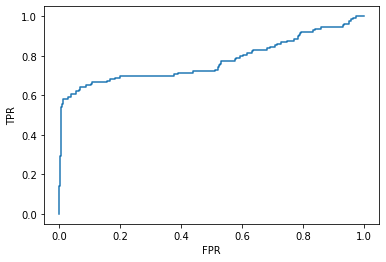

In [ ]:
XGB_model = grid_search_xgclf(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'],evaluation_scoring='f1')
evaluation(XGB_model,test_cop.drop(columns=['churn'], axis = 1),test_cop['churn'])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best score: 0.9167726977423405
Best model: {'C': 90, 'gamma': 'scale', 'kernel': 'rbf'}
Best f1 score: 0.9167726977423405
Best model: {'C': 90, 'gamma': 'scale', 'kernel': 'rbf'}
0.31836734693877555
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       721
           1       0.34      0.30      0.32       129

    accuracy                           0.80       850
   macro avg       0.61      0.60      0.60       850
weighted avg       0.80      0.80      0.80       850

0.5951036996419702


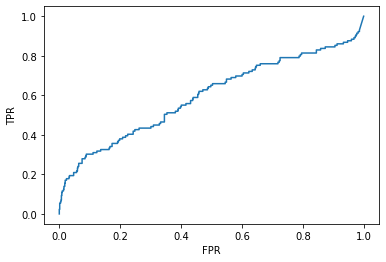

In [ ]:
svc_model = grid_search_svc(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'],evaluation_scoring='f1')
evaluation(svc_model,test_cop.drop(columns=['churn'], axis = 1),test_cop['churn'])

Best score: 0.8689846223517101
Best model: {'criterion': 'entropy', 'max_depth': 30, 'splitter': 'best'}
Best f1 score: 0.8689846223517101
Best model: {'criterion': 'entropy', 'max_depth': 30, 'splitter': 'best'}
0.5382059800664452
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       721
           1       0.47      0.63      0.54       129

    accuracy                           0.84       850
   macro avg       0.70      0.75      0.72       850
weighted avg       0.86      0.84      0.85       850

0.750588652711028


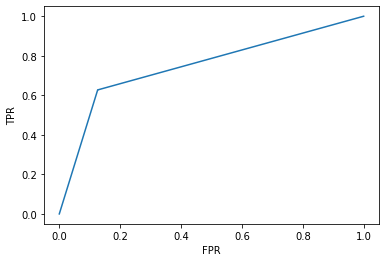

In [ ]:
#model with onehot yes/no feature
dt_model = grid_search_DT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'],evaluation_scoring='f1')
evaluation(dt_model,test_cop.drop(columns=['churn'], axis = 1),test_cop['churn'])

0.3944315545243619
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       721
           1       0.28      0.66      0.39       129

    accuracy                           0.69       850
   macro avg       0.60      0.68      0.59       850
weighted avg       0.82      0.69      0.73       850

0.7158124482576955


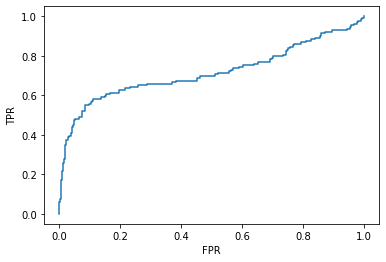

In [ ]:
lr_model = logistic_reg(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'])
evaluation(lr_model,test_cop.drop(columns=['churn'], axis = 1),test_cop['churn'], check = 0)

In [ ]:
print('Best f1 score:' ,tuned_model.best_score_)
print('Best model:' ,tuned_model.best_params_)

y_pred = tuned_model.predict(test_cop.drop(columns=['churn'], axis = 1))
print('{}'.format(accuracy_score(test_cop['churn'], y_pred)))
print('{}'.format(classification_report(test_cop['churn'], y_pred)))

y_pred_proba = tuned_model.predict_proba(test_cop.drop(columns=['churn'], axis = 1))
y_pred_proba
auc_score(test_cop['churn'],y_pred_proba[:,1])

# IBM churn data

In [ ]:
df_churn = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/churn.csv')
cols = df_churn.columns
dfs = df_churn.drop(labels = [cols[0],cols[1]], axis = 1)
dfs['Total Charges'] = [ float(dfs['Total Charges'][x]) if dfs['Total Charges'][x] != ' ' else dfs['Monthly Charges'][x] for x in range(len(dfs['Total Charges']))]

In [ ]:
numerical_feature = [x for x in dfs.columns if dfs[x].dtype != 'O']
categorical_feature = [x for x in dfs.columns if (dfs[x].dtype == 'O') & (x != 'Churn') ]

In [ ]:
train, test = train_test_split(dfs, test_size=0.2, shuffle=True, random_state = 42)
train_cop = remove_outliers(train, numerical_feature)
train_cop, test_cop = column_scaling(numerical_feature, train_cop, test)
train_cop, test_cop = one_hot(train_cop, test_cop, encode_cols=['Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing', 'Phone Service', 'Churn'])
train_cop = pd.get_dummies(train_cop, columns = ['Multiple Lines'	,'Internet Service'	,'Online Security',	'Online Backup',	'Device Protection'	,'Tech Support',	'Streaming TV',	'Streaming Movies', 'Contract','Payment Method'])
test_cop = pd.get_dummies(test_cop, columns = ['Multiple Lines'	,'Internet Service'	,'Online Security',	'Online Backup',	'Device Protection'	,'Tech Support',	'Streaming TV',	'Streaming Movies', 'Contract','Payment Method'])

train_cop = smote_oversampling(train_cop, result_col='Churn')

In [ ]:
XGB_model = grid_search_xgclf(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'],evaluation_scoring='f1')
evaluation(XGB_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'])

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


KeyboardInterrupt: ignored

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 1/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.727 total time=  11.3s
[CV 2/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 2/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.741 total time=  11.4s
[CV 3/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 3/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.865 total time=  12.2s
[CV 4/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 4/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.847 total time=  12.0s
[CV 5/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 5/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.864 total time=  12.4s
[CV 1/5; 2/10] START C=1, gamma=auto, kernel=rbf................................
[CV 1/5; 2/10] END .C=1, gamma=auto, kernel=rbf;

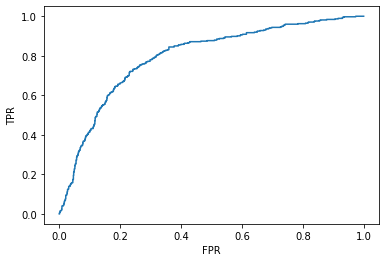

In [ ]:
svc_model = grid_search_svc(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'],evaluation_scoring='f1')
evaluation(svc_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'])

Best score: 0.7967047558996784
Best model: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}
Best f1 score: 0.7967047558996784
Best model: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}
0.5939933259176863
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1036
           1       0.51      0.72      0.59       373

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

0.7804506919788421


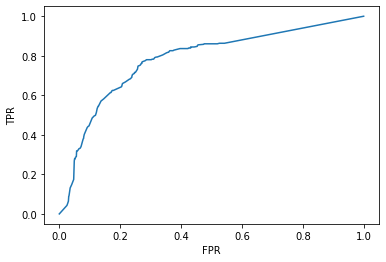

In [ ]:
#model with onehot yes/no feature
dt_model = grid_search_DT(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'],evaluation_scoring='f1')
evaluation(dt_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6588235294117646
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1036
           1       0.59      0.75      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.76      1409
weighted avg       0.82      0.79      0.80      1409

0.8584471104578344


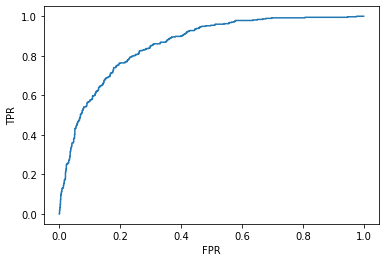

In [ ]:
lr_model = logistic_reg(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'])
evaluation(lr_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'], check = 0)

Best f1 score: 0.822142606944262
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 300, 'sub_sample': 0.6}
0.7693399574166075
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1036
           1       0.55      0.75      0.63       373

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



0.8526543107642305

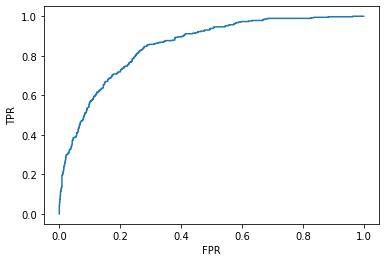

In [ ]:
print('Best f1 score:' ,tuned_model.best_score_)
print('Best model:' ,tuned_model.best_params_)

y_pred = tuned_model.predict(test_cop.drop(columns=['Churn'], axis = 1))
print('{}'.format(accuracy_score(test_cop['Churn'], y_pred)))
print('{}'.format(classification_report(test_cop['Churn'], y_pred)))

y_pred_proba = tuned_model.predict_proba(test_cop.drop(columns=['Churn'], axis = 1))
y_pred_proba
auc_score(test_cop['Churn'],y_pred_proba[:,1])

# Bank_dataset

In [ ]:
df_churn = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/bank_churn.csv')
cols = df_churn.columns
dfs = df_churn.drop(labels = [cols[0],cols[1],cols[2]], axis = 1)

In [ ]:
numerical_feature = [x for x in dfs.columns if (dfs[x].dtype != 'O') & (x!='Exited')]
categorical_feature = [x for x in dfs.columns if (dfs[x].dtype == 'O') ]

In [ ]:
train, test = train_test_split(dfs, test_size=0.2, shuffle=True, random_state = 42)
train_cop = remove_outliers(train, numerical_feature)
train_cop, test_cop = column_scaling(numerical_feature, train_cop, test)
train_cop = pd.get_dummies(train_cop, columns = ['Geography', 'Gender'])
test_cop = pd.get_dummies(test_cop, columns = ['Geography', 'Gender'])

train_cop = smote_oversampling(train_cop, result_col='Exited')

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best score: 0.879808814743609
Best model: {'colsample_bytree': 0.5, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 300, 'sub_sample': 0.6}
Best f1 score: 0.879808814743609
Best model: {'colsample_bytree': 0.5, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 300, 'sub_sample': 0.6}
0.6309226932668329
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1607
           1       0.62      0.64      0.63       393

    accuracy                           0.85      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000

0.861836969619239


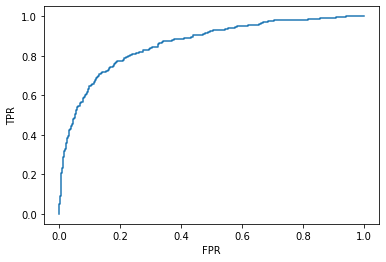

In [ ]:
#grid_search XGBoost
XGB_model = grid_search_xgclf(train_cop.drop(columns=['Exited'], axis = 1), train_cop['Exited'], evaluation_scoring='accuracy')
evaluation(XGB_model, test_cop.drop(columns=['Exited']),test_cop['Exited'], check = 1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 1/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.775 total time=  25.4s
[CV 2/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 2/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.791 total time=  25.6s
[CV 3/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 3/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.787 total time=  25.6s
[CV 4/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 4/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.782 total time=  25.5s
[CV 5/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 5/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.790 total time=  25.6s
[CV 1/5; 2/10] START C=1, gamma=auto, kernel=rbf................................
[CV 1/5; 2/10] END .C=1, gamma=auto, kernel=rbf;

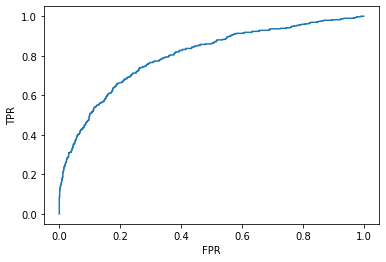

In [ ]:
#grid_search SVM

svc_model = grid_search_svc(train_cop.drop(columns=['Exited'], axis = 1), train_cop['Exited'], evaluation_scoring='f1')
evaluation(svc_model, test_cop.drop(columns=['Exited']),test_cop['Exited'], check = 1)

Best score: 0.8323158309890999
Best model: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}
Best f1 score: 0.8323158309890999
Best model: {'criterion': 'gini', 'max_depth': 30, 'splitter': 'random'}
0.4568965517241379
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1607
           1       0.40      0.54      0.46       393

    accuracy                           0.75      2000
   macro avg       0.64      0.67      0.65      2000
weighted avg       0.78      0.75      0.76      2000

0.6692222797525458


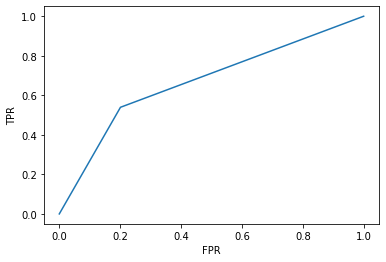

In [ ]:
#grid_search DT
DT_model = grid_search_DT(train_cop.drop(columns=['Exited'], axis = 1), train_cop['Exited'], evaluation_scoring='f1')
evaluation(DT_model, test_cop.drop(columns=['Exited']),test_cop['Exited'], check = 1)


0.4870466321243523
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1607
           1       0.37      0.72      0.49       393

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000

0.7794588243863123


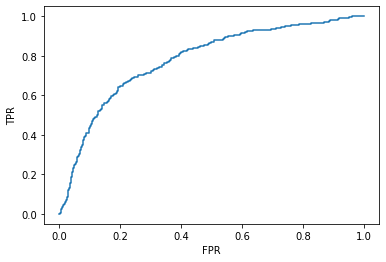

In [ ]:
#lrmodel
lr_model = logistic_reg(train_cop.drop(columns=['Exited'], axis = 1), train_cop['Exited'])
evaluation(lr_model, test_cop.drop(columns=['Exited']),test_cop['Exited'], check = 0)


# Orange dataset


In [ ]:
df_churn = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/Data bcl2/cdr_2020.csv')
cols = df_churn.columns
dfs = df_churn.drop(labels = [cols[0],cols[1]], axis = 1)

In [ ]:
train, test = train_test_split(dfs,test_size=0.2, shuffle = True, random_state = 42)

train_cop = remove_outliers(train, dfs.columns[:-1])
train_cop, test_cop = one_hot(train_cop, test, ['Churn'])
train_cop = smote_oversampling(train_cop, "Churn")


train_cop, test_cop = column_scaling(dfs.columns[:-1], train_cop, test_cop)
# train_cop



```
# Grid search mô hình tốt nhất XGBoost
```



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best score: 0.8987155233470612
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
Best f1 score: 0.8987155233470612
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
0.43118699855996706
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     18152
           1       0.38      0.50      0.43      2083

    accuracy                           0.86     20235
   macro avg       0.66      0.70      0.68     20235
weighted avg       0.88      0.86      0.87     20235

0.8042796102554901


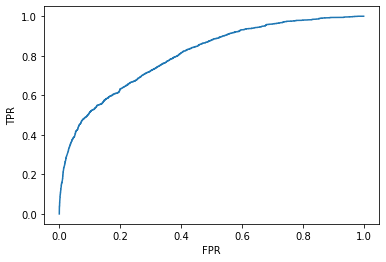

In [ ]:
XGB_model = grid_search_xgclf(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'], evaluation_scoring='f1')
evaluation(XGB_model, test_cop.drop(columns=['Churn']),test_cop['Churn'], check = 1)



```
# Phân tích kết quả
```



In [ ]:
XGB_model = XGBClassifier(objective = 'binary:logistic',n_jobs=-1,colsample_bytree=0.7, learning_rate=0.005, max_depth=9, n_estimators=500, sub_sample=0.7, random_state=42)
XGB_model.fit(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'])

XGBClassifier(colsample_bytree=0.7, learning_rate=0.005, max_depth=9,
              n_estimators=500, n_jobs=-1, random_state=42, sub_sample=0.7)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


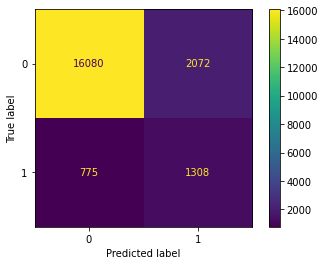

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(XGB_model, test_cop.drop(columns=['Churn']),test_cop['Churn'])  
plt.show()

In [ ]:
test['pred'] = XGB_model.predict(test_cop.drop(columns=['Churn']))
train, test = one_hot(train, test, ['Churn'])

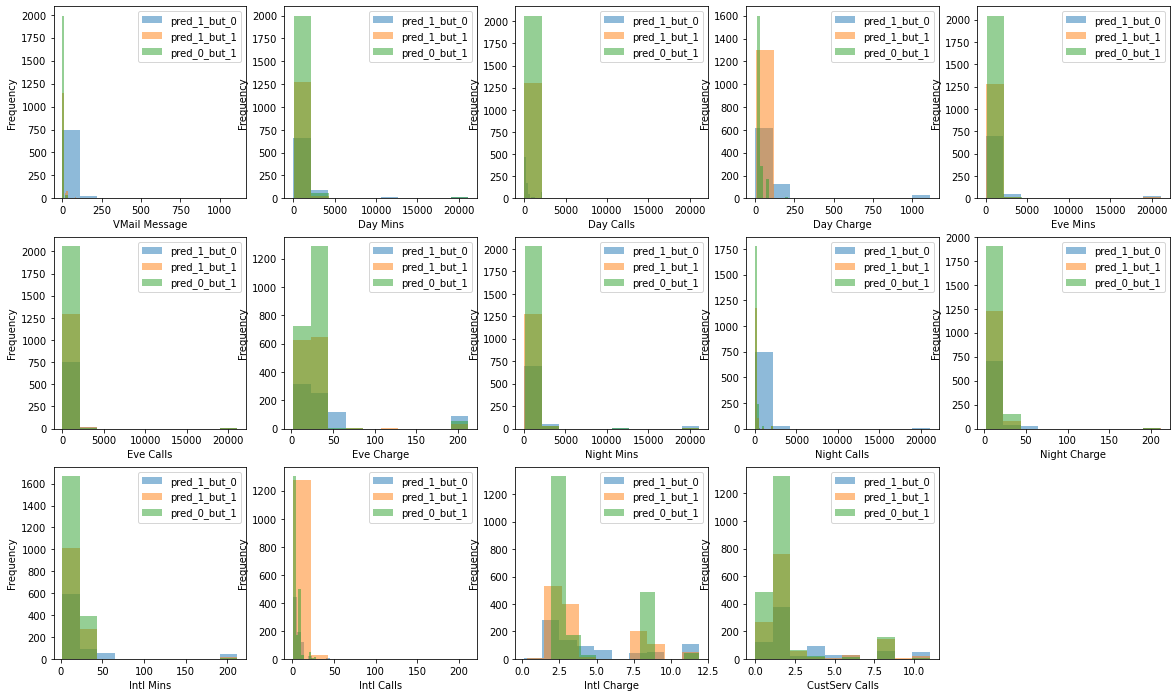

In [ ]:
a = 1
plt.figure(figsize=(20, 12))
for i in test.columns:
  if ((i != 'Churn') & (i!='pred')):
    plt.subplot(3,5,a)
    test.loc[(test['Churn']==1)&(test['pred']==0)][i].plot.hist(alpha=0.5)
    test.loc[(test['Churn']==1)&(test['pred']==1)][i].plot.hist(alpha=0.5)
    test.loc[(test['Churn']==0)&(test['pred']==1)][i].plot.hist(alpha=0.5)
    
    plt.xlabel(i)
    plt.legend(['pred_1_but_0', 'pred_1_but_1','pred_0_but_1'])
    # plt.show()
    a+=1
plt.show()

In [ ]:
print('{}'.format(classification_report(test_cop['Churn'],XGB_model.predict( test_cop.drop(columns=['Churn'])))))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92     18152
           1       0.39      0.63      0.48      2083

    accuracy                           0.86     20235
   macro avg       0.67      0.76      0.70     20235
weighted avg       0.90      0.86      0.87     20235



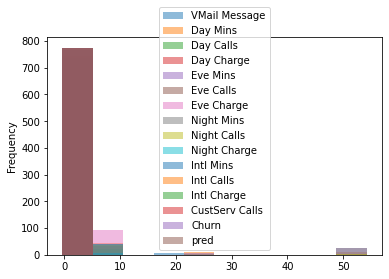

In [ ]:
test_cop.loc[(test_cop['Churn']==1)&(test_cop['pred']==0)].plot.hist(alpha=0.5)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best score: 0.894468202510691
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
Best f1 score: 0.894468202510691
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
0.4788577704557934
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     18152
           1       0.39      0.63      0.48      2083

    accuracy                           0.86     20235
   macro avg       0.67      0.76      0.70     20235
weighted avg       0.90      0.86      0.87     20235

0.8519682673247111


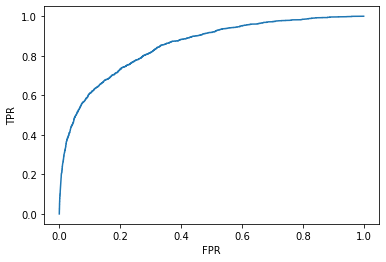

In [ ]:
XGB_model = grid_search_xgclf(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'], evaluation_scoring='accuracy')
evaluation(XGB_model, test_cop.drop(columns=['Churn']),test_cop['Churn'], check = 1)

0.19798835362625727
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     18152
           1       0.12      0.54      0.20      2083

    accuracy                           0.55     20235
   macro avg       0.52      0.55      0.44     20235
weighted avg       0.83      0.55      0.64     20235

0.5491072269227246


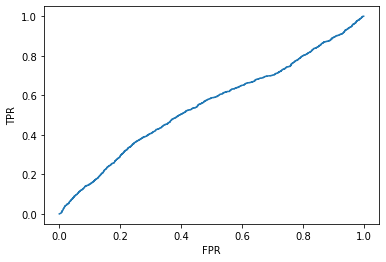

In [ ]:
lr_model = logistic_reg(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'])
evaluation(lr_model, test_cop.drop(columns=['Churn']),test_cop['Churn'], check = 0)

Best score: 0.8493515270930543
Best model: {'criterion': 'entropy', 'max_depth': 30, 'splitter': 'best'}
Best f1 score: 0.8493515270930543
Best model: {'criterion': 'entropy', 'max_depth': 30, 'splitter': 'best'}
0.4007510729613734
              precision    recall  f1-score   support

           0       0.96      0.79      0.86     18152
           1       0.28      0.72      0.40      2083

    accuracy                           0.78     20235
   macro avg       0.62      0.75      0.63     20235
weighted avg       0.89      0.78      0.82     20235

0.7509870905038943


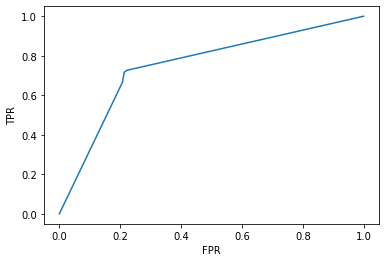

In [ ]:
#model with onehot yes/no feature
dt_model = grid_search_DT(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'],evaluation_scoring='f1')
evaluation(dt_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 1/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.669 total time= 1.3min
[CV 2/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 2/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.677 total time= 1.2min
[CV 3/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 3/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.683 total time= 1.2min
[CV 4/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 4/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.681 total time= 1.2min
[CV 5/5; 1/10] START C=1, gamma=scale, kernel=rbf...............................
[CV 5/5; 1/10] END C=1, gamma=scale, kernel=rbf;, score=0.677 total time= 1.2min
[CV 1/5; 2/10] START C=1, gamma=auto, kernel=rbf................................
[CV 1/5; 2/10] END .C=1, gamma=auto, kernel=rbf;

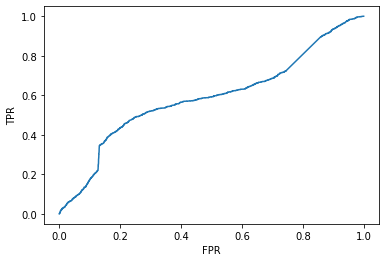

In [ ]:
svc_model = grid_search_svc(train_cop.drop(columns=['Churn'], axis = 1), train_cop['Churn'],evaluation_scoring='f1')
evaluation(svc_model,test_cop.drop(columns=['Churn'], axis = 1),test_cop['Churn'])

In [ ]:
dfs

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101169,0,228.2,60,22.82,229.8,289,28.26,222.8,222,2.28,6.2,2,2.62,2,False
101170,0,282.2,222,82.88,208.8,220,22.82,282.2,200,20.68,9.8,8,2.82,8,False
101171,0,222.2,62,88.66,228.0,228,22.08,62.2,209,2.26,2.8,6,2.22,2,False
101172,0,222.0,99,88.08,220.2,80,22.92,282.9,28,20.22,2.2,8,0.82,0,False


In [ ]:
train.loc[train['Churn'] == 1]

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
4411,0,544.5,445,54.7900,444.0,95,48.87,464.8,445,7.55,6.7,8,4.840,0,True
1018,0,263.4,148,44.7800,230.3,69,19.58,170.6,101,7.68,11.4,5,3.080,1,True
35269,0,2211.2,200,22.1111,222.2,62,29.11,2211.2,21111,11.02,9.2,2,2.211,2,True
13933,0,289.2,86,22.2800,292.8,26,26.29,222.6,208,8.22,28.9,6,8.280,0,True
57629,88,322.9,208,29.2800,328.2,208,32.20,262.6,326,2.32,28.8,8,8.680,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0,274.0,92,46.5800,231.8,82,19.70,283.6,83,12.76,6.2,1,1.670,0,True
25658,0,262.2,22,23.2200,232.3,29,22.20,232.2,93,3.23,9.2,2,2.320,6,True
28693,0,223.9,69,22.3000,203.2,222,22.20,230.9,206,3.22,22.2,20,3.390,0,True
83104,0,249.4,49,24.3400,292.4,94,23.44,242.0,24,3.40,9.4,4,2.420,2,True


In [ ]:
test.loc[test['Churn'] == 1]

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
6501,0,445.9,440,58.40,499.4,86,45.44,454.5,84,44.54,44.4,4,5.04,4,True
32986,0,223.2,222,29.32,222.3,20,22.96,236.2,33,6.22,23.3,3,3.23,2,True
22565,0,222.2,226,22.02,303.2,203,23.32,203.2,92,2.22,9.3,2,2.32,2,True
54879,0,268.2,206,28.32,328.2,209,28.26,320.0,98,9.28,8.2,8,2.88,0,True
19530,82,90.0,82,28.80,226.8,228,28.29,288.2,202,8.88,8.6,6,2.82,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93568,0,298.8,99,88.28,262.8,60,22.26,882.9,28,28.92,9.2,8,2.82,0,True
31119,0,239.2,203,32.23,226.2,222,20.92,222.0,206,20.39,20.2,3,2.32,2,True
24864,0,222.2,202,22.22,226.2,30,29.22,232.0,96,22.32,23.9,3,3.23,2,True
29066,33,223.0,202,22.32,222.2,202,23.02,202.9,220,2.22,23.3,2,2.23,3,True


# Sparkify dataset 


## Basic method

In [ ]:
from math import sqrt
df_churn = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/Sparkify/export (1).csv')
df_churn = df_churn.drop(['userId'], axis = 1)
df_churn = df_churn.dropna(how='any', axis = 0, subset=['time_since_regi'])


In [ ]:
len(df_churn)

22277

In [ ]:
import math
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]

for i in df_churn.columns:
  if i in to_sqrt:
    df_churn[i] = [sqrt(x) for x in df_churn[i]]
  if i in to_log:
    print(i)
    df_churn[i] = [math.log2(x) if x != 0 else 0 for x in df_churn[i]]



page_about
page_error
page_roll_advert
page_save_settings
page_thumbs_down
page_thumbs_up
page_frac_about
page_frac_add_friend
page_frac_add_to_playlist
page_frac_error
page_frac_help
page_frac_home
page_frac_logout
page_frac_roll_advert
page_frac_save_settings
page_frac_settings
page_frac_submit_downgrade
page_frac_submit_upgrade
page_frac_thumbs_down


In [ ]:
train, test = train_test_split(df_churn, test_size = 0.2, shuffle = True, random_state = 42)

# train_cop = remove_outliers(train, ['time_since_regi', 'std_time_per_session'])

train_cop = smote_oversampling(train, 'churn')



```
Decistion Tree model

```



Best score: 0.8060958767385127
Best model: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Best f1 score: 0.8060958767385127
Best model: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.5204545454545454
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3432
           1       0.62      0.45      0.52      1024

    accuracy                           0.81      4456
   macro avg       0.74      0.68      0.70      4456
weighted avg       0.80      0.81      0.80      4456

0.7429044141080274


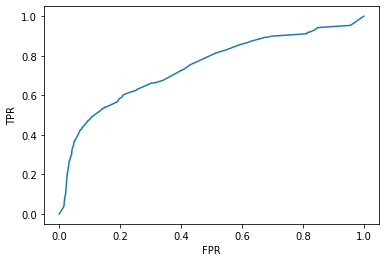

In [ ]:
#dt_model
dt_model = grid_search_DT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='f1')
evaluation(dt_model, test.drop(columns=['churn']),test['churn'], check = 1)

In [ ]:
GB_model = grid_search_GBT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='f1')


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.8470416302059306
Best model: {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 9, 'n_estimators': 250}


Best f1 score: 0.8470416302059306
Best model: {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 9, 'n_estimators': 250}
0.5390995260663507
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3432
           1       0.69      0.44      0.54      1024

    accuracy                           0.83      4456
   macro avg       0.77      0.69      0.72      4456
weighted avg       0.81      0.83      0.81      4456

0.7958295773237181


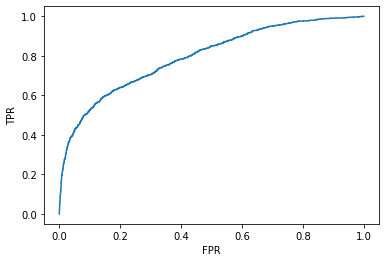

In [ ]:
evaluation(GB_model, test.drop(columns=['churn']),test['churn'], check = 1)
#like project angangli



```
Đánh giá và phân tích kết quả mô hình XGboost
```



Best f1 score: 0.8738287542240795
Best model: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
0.549490101979604
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3432
           1       0.71      0.45      0.55      1024

    accuracy                           0.83      4456
   macro avg       0.78      0.70      0.72      4456
weighted avg       0.82      0.83      0.82      4456

0.8050695032506556


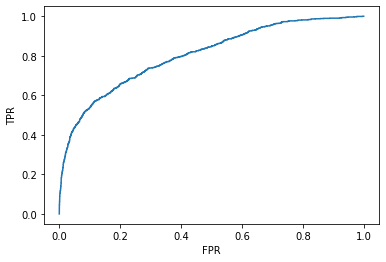

In [ ]:
#oversampling XGB_model
evaluation(XGB_model, test.drop(columns=['churn']),test['churn'], check = 1)
# train_cop

In [ ]:
#oversampling XGB_model
XGB_model = XGBClassifier(objective = 'binary:logistic',n_jobs=-1,colsample_bytree=0.8, learning_rate=0.005, max_depth=9, n_estimators=500, sub_sample=0.7, random_state=42)
XGB_model.fit(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'])

XGBClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=9,
              n_estimators=500, n_jobs=-1, random_state=42, sub_sample=0.7)

In [ ]:
print('{}'.format(classification_report(test['churn'],XGB_model.predict( test.drop(columns=['churn'])))))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3432
           1       0.73      0.43      0.54      1024

    accuracy                           0.83      4456
   macro avg       0.79      0.69      0.72      4456
weighted avg       0.82      0.83      0.81      4456



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


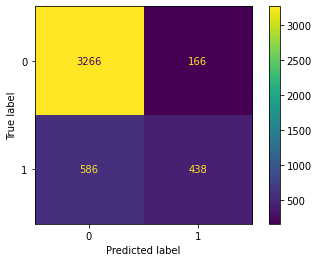

In [ ]:
plot_confusion_matrix(XGB_model, test.drop(columns=['churn']),test['churn'])  
plt.show()

In [ ]:
test['pred'] = XGB_model.predict( test.drop(columns=['churn']))
# a = 1
# plt.figure(figsize=(20, 12))
# for i in test.columns:
#   if ((i != 'churn') & (i!='pred')):
#     plt.subplot(3,5,a)
#     test.loc[(test['Churn']==1)&(test['pred']==0)][i].plot.hist(alpha=0.5)
#     test.loc[(test['Churn']==1)&(test['pred']==1)][i].plot.hist(alpha=0.5)
#     test.loc[(test['Churn']==0)&(test['pred']==1)][i].plot.hist(alpha=0.5)
    
#     plt.xlabel(i)
#     plt.legend(['pred_1_but_0', 'pred_1_but_1','pred_0_but_1'])
#     # plt.show()
#     a+=1
# plt.show()
test

,churn,level,time_since_regi,gender,std_time_per_session,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,user_agent_iPad,user_agent_iPhone,page_about,page_error,page_roll_advert,page_save_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_frac_about,page_frac_add_friend,page_frac_add_to_playlist,page_frac_error,page_frac_help,page_frac_home,page_frac_logout,page_frac_nextsong,page_frac_roll_advert,page_frac_save_settings,page_frac_settings,page_frac_submit_downgrade,page_frac_submit_upgrade,page_frac_thumbs_down,page_frac_thumbs_up,pred
8605,1,1,8036614.0,1.0,163.692374,0.0,0.0,1.0,0.0,0.0,0.0,2.000000,1.0,4.169925,2.000000,0,1,4.247928,6.977280,-9.674192,-5.866837,-5.166398,-10.674192,-8.089230,-4.779375,-6.316640,0.843329,-7.504267,-9.674192,-7.426265,0.000000,-11.674192,-7.426265,0.038556,0
9540,0,0,5525557.0,0.0,117.762529,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.807355,0.000000,2,1,3.700440,4.584963,0.000000,-6.192645,-5.192645,0.000000,-8.000000,-4.415037,-6.000000,0.779297,-5.192645,0.000000,-7.000000,-8.000000,-9.000000,-5.299560,0.046875,0
11128,0,1,6688123.0,1.0,166.896267,0.0,1.0,0.0,0.0,0.0,0.0,2.321928,0.0,0.000000,1.584963,0,0,3.584963,6.149747,-8.459432,-6.321928,-5.196397,-10.781360,-8.196397,-5.080920,-7.196397,0.861364,0.000000,-9.196397,-7.196397,0.000000,0.000000,-7.196397,0.040341,0
8343,1,1,9749227.0,1.0,95.441202,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,6.442943,2.000000,2,3,3.700440,6.409391,-10.068778,-6.210797,-5.783376,-11.068778,-7.368339,-4.498923,-6.068778,0.805400,-4.625835,-9.068778,-7.368339,-10.068778,-9.483816,-7.368339,0.039572,0
6533,0,1,9163886.0,0.0,138.733456,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,5.554589,0.000000,0,1,2.807355,4.584963,-9.375039,-6.053111,-5.790077,-8.375039,-7.790077,-4.851477,-6.375039,0.787651,-3.820451,0.000000,-7.790077,0.000000,-9.375039,-6.567685,0.036145,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17012,0,1,10176115.0,1.0,147.013606,1.0,0.0,0.0,0.0,0.0,0.0,2.584963,0.0,1.000000,2.000000,0,0,3.584963,6.375039,-8.371414,-5.911982,-5.432814,0.000000,-7.255936,-5.098395,-6.956376,0.856568,-9.956376,-8.956376,-7.371414,0.000000,0.000000,-7.371414,0.041772,0
10622,1,0,6429116.0,1.0,99.700386,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.584963,0.000000,0,0,1.584963,3.169925,0.000000,-6.837102,-5.252140,-8.422065,-8.422065,-4.614710,-5.422065,0.711370,-2.837102,0.000000,-6.837102,0.000000,0.000000,-6.837102,0.026239,1
7089,0,1,6659157.0,1.0,165.219139,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0,1,2.000000,5.169925,-8.375039,-7.790077,-5.127112,-9.375039,-7.790077,-4.468149,-7.790077,0.840361,-9.375039,0.000000,-7.790077,0.000000,-9.375039,-7.375039,0.054217,0
11380,1,0,7661871.0,1.0,66.818163,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,4.000000,0.000000,0,0,0.000000,2.321928,0.000000,-7.219169,-6.219169,-7.219169,0.000000,-3.518729,-5.219169,0.711409,-3.219169,0.000000,0.000000,0.000000,0.000000,-7.219169,0.033557,0


Best f1 score: 0.7376216405724411
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 500, 'sub_sample': 0.7}
0.5718120805369127
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      3432
           1       0.53      0.62      0.57      1024

    accuracy                           0.79      4456
   macro avg       0.70      0.73      0.71      4456
weighted avg       0.80      0.79      0.79      4456

0.8149994536713288


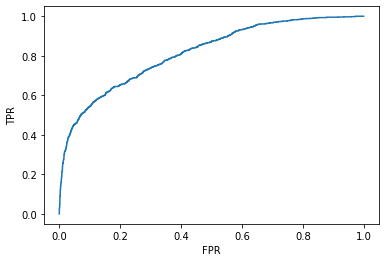

In [ ]:
evaluation(XGB_model, test.drop(columns=['churn']),test['churn'], check = 1)
#under

In [ ]:
GB_model = grid_search_GBT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.87704366108815
Best model: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 9, 'n_estimators': 50}


Best f1 score: 0.7362390203689724
Best model: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 5, 'n_estimators': 500}
0.5713012477718359
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      3432
           1       0.53      0.63      0.57      1024

    accuracy                           0.78      4456
   macro avg       0.70      0.73      0.71      4456
weighted avg       0.80      0.78      0.79      4456

0.8135501176883012


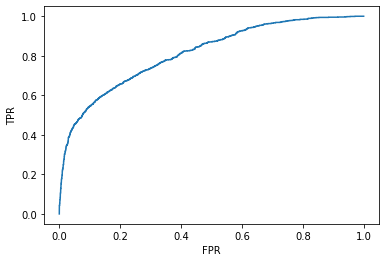

In [ ]:
evaluation(GB_model, test.drop(columns=['churn']),test['churn'], check = 1)


Best f1 score: 0.87704366108815
Best model: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 9, 'n_estimators': 50}
0.5439330543933054
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3432
           1       0.70      0.44      0.54      1024

    accuracy                           0.83      4456
   macro avg       0.78      0.69      0.72      4456
weighted avg       0.82      0.83      0.81      4456

0.7966015511181528


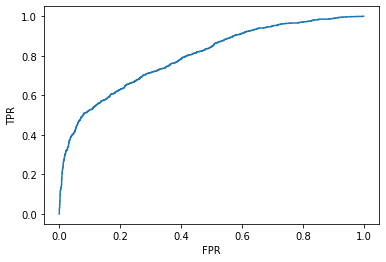

In [ ]:
evaluation(GB_model, test.drop(columns=['churn']),test['churn'], check = 1)


In [ ]:
GB_model = DT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')




In [ ]:
df_churn.columns

Index(['churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session',
       'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11',
       'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone',
       'page_about', 'page_error', 'page_roll_advert', 'page_save_settings',
       'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down',
       'page_thumbs_up', 'page_frac_about', 'page_frac_add_friend',
       'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help',
       'page_frac_home', 'page_frac_logout', 'page_frac_nextsong',
       'page_frac_roll_advert', 'page_frac_save_settings',
       'page_frac_settings', 'page_frac_submit_downgrade',
       'page_frac_submit_upgrade', 'page_frac_thumbs_down',
       'page_frac_thumbs_up'],
      dtype='object')

In [ ]:
import math
a = ['std_time_per_session','page_about', 'page_error', 'page_roll_advert', 'page_save_settings',
'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down',
'page_thumbs_up', 'page_frac_about', 'page_frac_add_friend',
'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help',
'page_frac_home', 'page_frac_logout', 'page_frac_nextsong',
'page_frac_roll_advert', 'page_frac_save_settings',
'page_frac_settings', 'page_frac_submit_downgrade',
'page_frac_submit_upgrade', 'page_frac_thumbs_down',
'page_frac_thumbs_up']
for i in a:
  print(i)
  df_churn[i] = [sqrt(x) for x in df_churn[i]]

std_time_per_session
page_about
page_error
page_roll_advert
page_save_settings
page_submit_downgrade
page_submit_upgrade
page_thumbs_down
page_thumbs_up
page_frac_about
page_frac_add_friend
page_frac_add_to_playlist
page_frac_error
page_frac_help
page_frac_home
page_frac_logout
page_frac_nextsong
page_frac_roll_advert
page_frac_save_settings
page_frac_settings
page_frac_submit_downgrade
page_frac_submit_upgrade
page_frac_thumbs_down
page_frac_thumbs_up


In [ ]:
train, test = train_test_split(df_churn, test_size = 0.2, shuffle = True, random_state = 42)
train_cop, test = column_scaling(['time_since_regi', 'std_time_per_session'], train, test)

train_cop = undersampling(train_cop, 'churn')

In [ ]:
XGB_model = grid_search_xgclf(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best score: 0.7368679506899678
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 500, 'sub_sample': 0.7}


Best f1 score: 0.7368679506899678
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 500, 'sub_sample': 0.7}
0.5643262102049716
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3432
           1       0.51      0.63      0.56      1024

    accuracy                           0.78      4456
   macro avg       0.70      0.73      0.71      4456
weighted avg       0.80      0.78      0.78      4456

0.8145739148546766


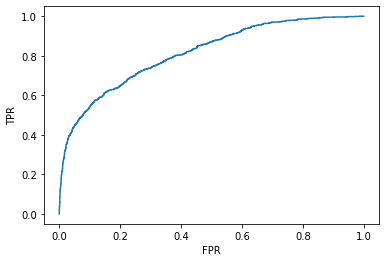

In [ ]:
evaluation(XGB_model, test.drop(columns=['churn']),test['churn'], check = 1)

In [ ]:
GB_model = grid_search_GBT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.7363657539741448
Best model: {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500}


Best f1 score: 0.7363657539741448
Best model: {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500}
0.5671378091872792
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3432
           1       0.52      0.63      0.57      1024

    accuracy                           0.78      4456
   macro avg       0.70      0.73      0.71      4456
weighted avg       0.80      0.78      0.79      4456

0.8126869468422203


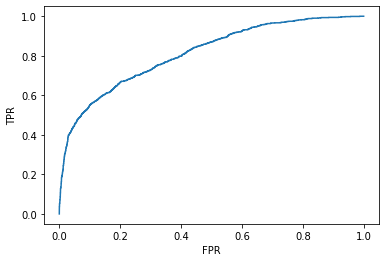

In [ ]:
evaluation(GB_model, test.drop(columns=['churn']),test['churn'], check = 1)


In [ ]:
pred = GB_model.predict(test.drop(columns=['churn']))
test['pred'] = pred

In [ ]:
fal = test.loc[test['churn'] != test['pred']]
tru = test.loc[test['churn'] == test['pred']]

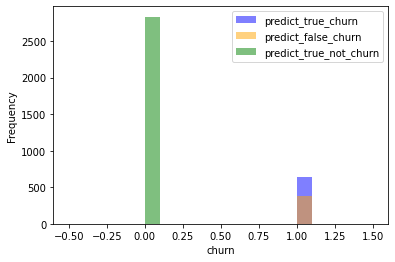

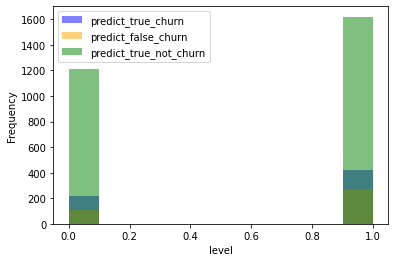

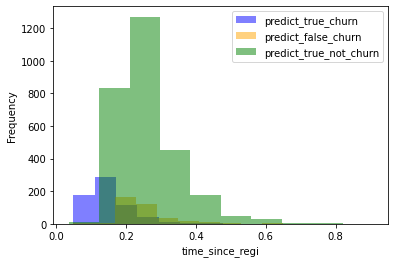

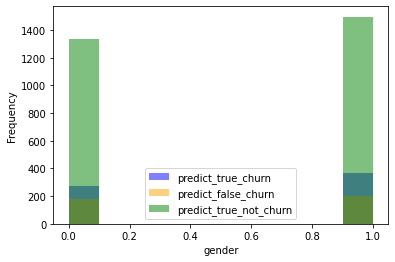

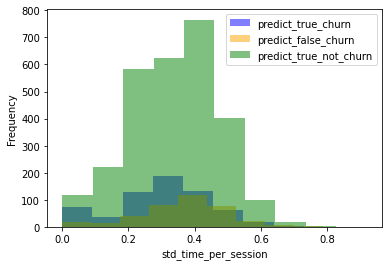

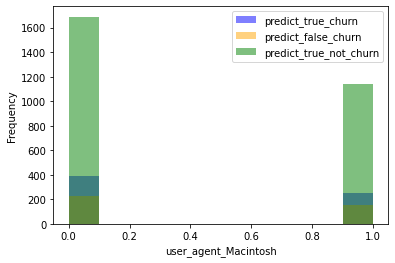

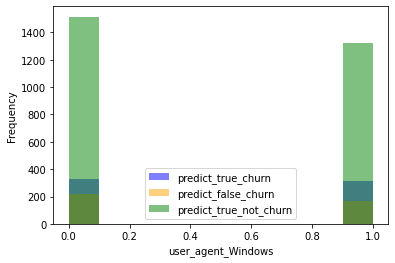

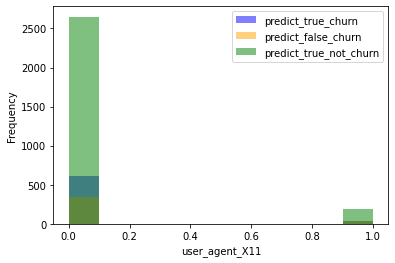

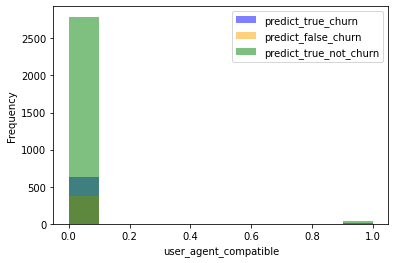

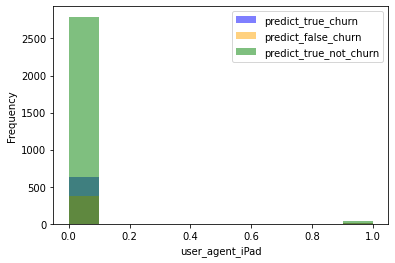

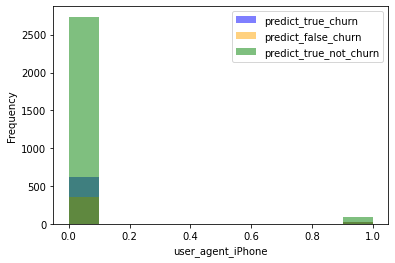

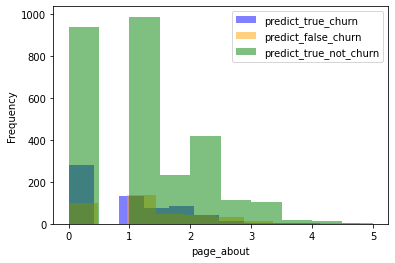

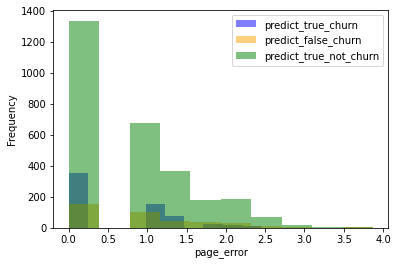

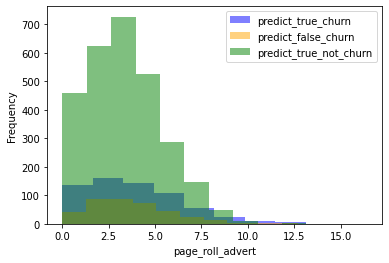

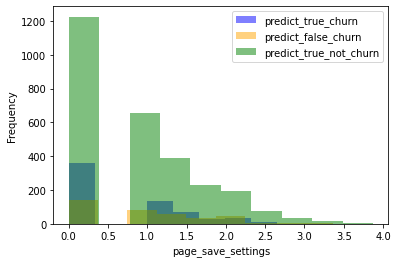

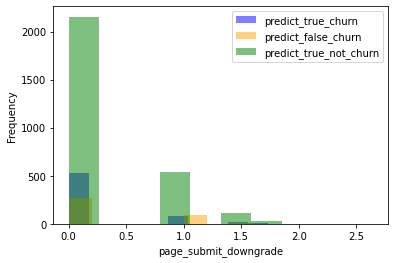

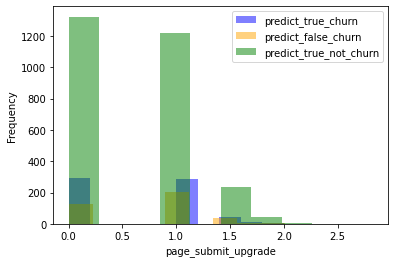

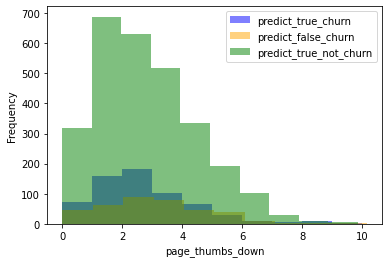

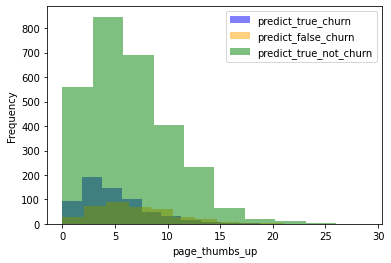

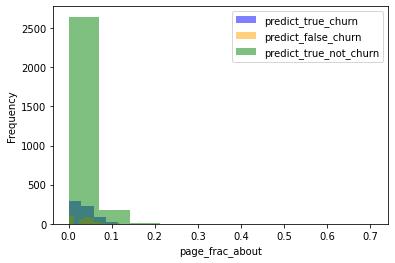

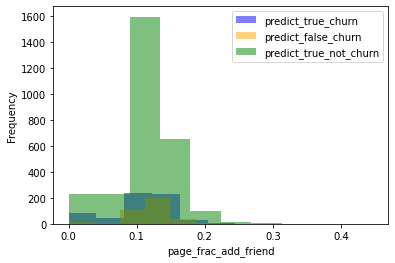

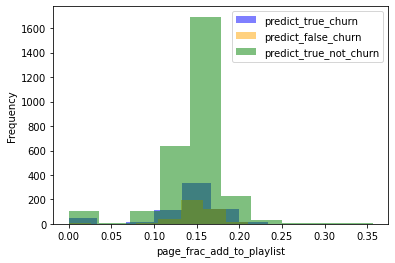

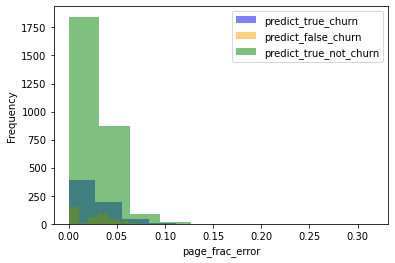

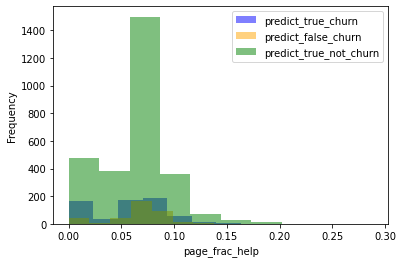

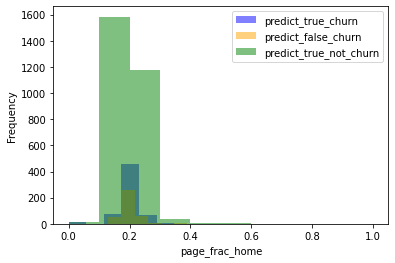

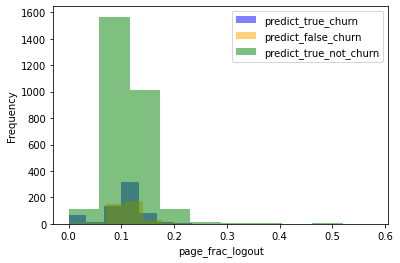

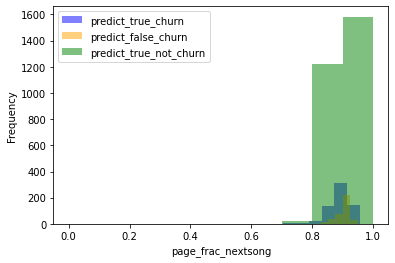

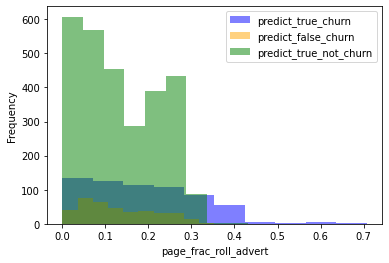

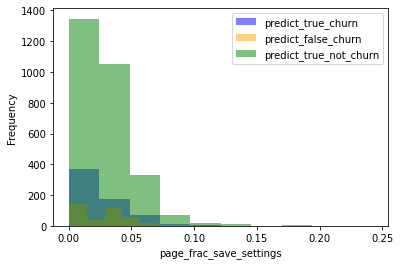

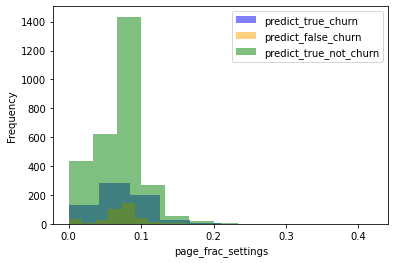

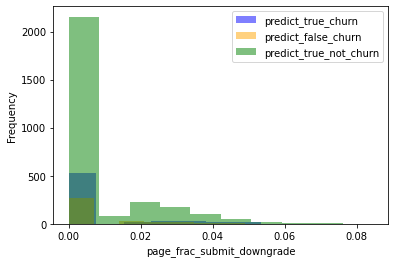

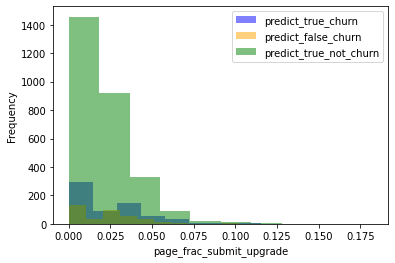

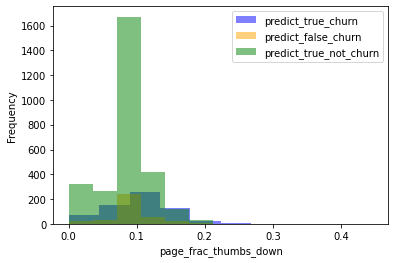

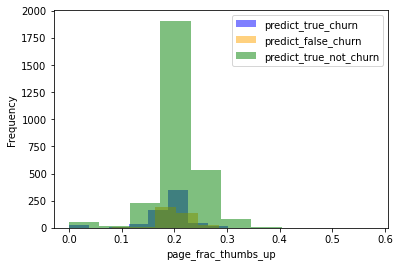

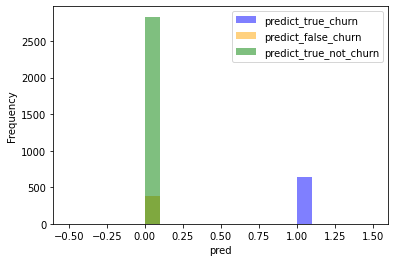

In [ ]:
for i in test.columns:
  tru.loc[tru['pred'] == 1][i].plot.hist(alpha = 0.5, color = 'blue')
  fal.loc[fal['pred'] == 0][i].plot.hist(alpha = 0.5, color = 'orange')
  tru.loc[tru['pred'] == 0][i].plot.hist(alpha = 0.5, color = 'green')
  plt.xlabel(i)
  plt.legend(['predict_true_churn','predict_false_churn', 'predict_true_not_churn'])
  plt.show()

## Weighted Average method

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Đại học/Data/Churn/Sparkify/test_part2_sparkify.csv')
df.head()


,userId,churn,gender,level,sum_song_listened,Thumb_up_times,Thumb_down_times,Num_ads,last_interaction,days_from_last_interaction,wavg_action,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,user_agent_iPad,user_agent_iPhone,location_east_north_central,location_east_south_central,location_middle_atlantic,location_mountain,location_new_england,location_pacific,location_south_atlantic,location_west_north_central,location_west_south_central
0,1390009,1,1,1,179.0,15.0,2.0,NaN,1540546610000,35.599445,0.020173,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1
1,1519090,0,0,0,308.0,16.0,2.0,33.0,1542913610000,8.203611,4.695457,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0
2,1394508,0,1,0,1106.0,50.0,16.0,50.0,1543342746000,3.236759,7.817728,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
3,1178731,0,0,1,2323.0,147.0,27.0,7.0,1543604099000,0.211840,41.769093,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0
4,1351489,0,1,1,954.0,56.0,8.0,1.0,1543426337000,2.269271,22.732378,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0


In [ ]:
"df = df.drop(['last_interaction'], axis =1)

In [ ]:
df[['sum_song_listened','Thumb_up_times','Thumb_down_times','Num_ads']] = df[['sum_song_listened','Thumb_up_times','Thumb_down_times','Num_ads']].fillna(0)
df.isnull().any()

userId                         False
churn                          False
gender                         False
level                          False
sum_song_listened              False
Thumb_up_times                 False
Thumb_down_times               False
Num_ads                        False
last_interaction               False
days_from_last_interaction     False
wavg_action                    False
user_agent_Macintosh           False
user_agent_Windows             False
user_agent_X11                 False
user_agent_compatible          False
user_agent_iPad                False
user_agent_iPhone              False
location_east_north_central    False
location_east_south_central    False
location_middle_atlantic       False
location_mountain              False
location_new_england           False
location_pacific               False
location_south_atlantic        False
location_west_north_central    False
location_west_south_central    False
dtype: bool

In [ ]:
#mất những dữ liệu bị na, có lẽ sẽ bị lệch dữ liệu (dữ liệu hoàn hảo)
train, test = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 42)
# train_cop = remove_outliers(train, ['time_since_regi', 'std_time_per_session'])

train_cop = smote_oversampling(train, 'churn')

In [ ]:
train_cop = train_cop.drop(['days_from_last_interaction','last_interaction'],axis=1)
test = test.drop(['days_from_last_interaction','last_interaction'],axis=1)


In [ ]:
model = XGBClassifier(objective='binary:logistic',random_state= 42,colsample_bytree= 0.7, learning_rate= 0.005, max_depth= 9, n_estimators= 500, sub_sample= 0.7)
model.fit(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'])

XGBClassifier(colsample_bytree=0.7, learning_rate=0.005, max_depth=9,
              n_estimators=500, random_state=42, sub_sample=0.7)

In [ ]:
print('{}'.format(classification_report(test['churn'],model.predict( test.drop(columns=['churn'])))))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3489
           1       0.78      0.66      0.72       967

    accuracy                           0.89      4456
   macro avg       0.84      0.81      0.82      4456
weighted avg       0.88      0.89      0.88      4456



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best score: 0.9297869397636479
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
Best f1 score: 0.9297869397636479
Best model: {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 500, 'sub_sample': 0.7}
0.8112911657083115
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3489
           1       0.82      0.80      0.81       967

    accuracy                           0.92      4456
   macro avg       0.88      0.88      0.88      4456
weighted avg       0.92      0.92      0.92      4456

0.9413509084393764


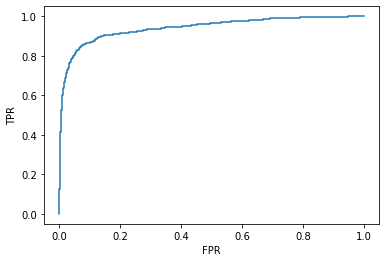

In [ ]:
evaluation(XGB_model, test.drop(columns=['churn']),test['churn'], check = 1)
XGB_model = grid_search_xgclf(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


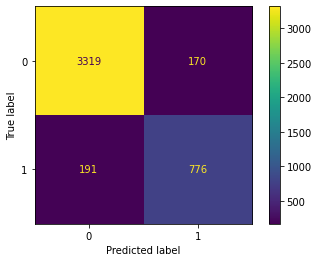

In [ ]:
plot_confusion_matrix(XGB_model, test.drop(columns=['churn']),test['churn'])  
plt.show()

Best score: 0.9015333720709602
Best model: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Best f1 score: 0.9015333720709602
Best model: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.7690732206861239
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3489
           1       0.76      0.78      0.77       967

    accuracy                           0.90      4456
   macro avg       0.85      0.85      0.85      4456
weighted avg       0.90      0.90      0.90      4456

0.8978652956566405


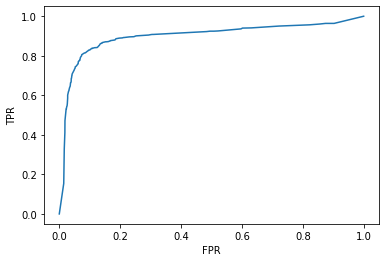

In [ ]:
#dt_model
dt_model = grid_search_DT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='accuracy')
evaluation(dt_model, test.drop(columns=['churn']),test['churn'], check = 1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.9311493560485031
Best model: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 9, 'n_estimators': 500}
Best f1 score: 0.9311493560485031
Best model: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 9, 'n_estimators': 500}
0.8143009605122733
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3489
           1       0.84      0.79      0.81       967

    accuracy                           0.92      4456
   macro avg       0.89      0.87      0.88      4456
weighted avg       0.92      0.92      0.92      4456

0.9389195708302324


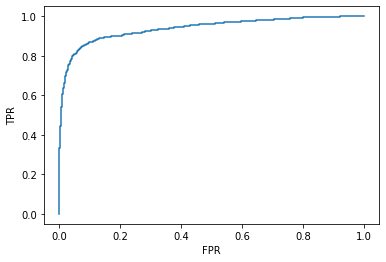

In [ ]:
GB_model = grid_search_GBT(train_cop.drop(columns=['churn'], axis = 1), train_cop['churn'], evaluation_scoring='f1')
evaluation(GB_model, test.drop(columns=['churn']),test['churn'], check = 1)